<a href="https://colab.research.google.com/github/adampotton/Cognitive_AI_CW/blob/main/Q2A_LSTM_BI_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Adpating the LSTM model cost function to tackle sparsity

### Install NeuroGym

In [1]:
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

Cloning into 'neurogym'...
remote: Enumerating objects: 11100, done.
remote: Counting objects: 100% (1001/1001), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 11100 (delta 928), reused 898 (delta 898), pack-reused 10099 (from 1)
Receiving objects: 100% (11100/11100), 8.17 MiB | 10.29 MiB/s, done.
Resolving deltas: 100% (8335/8335), done.
/content/neurogym
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.4/696.4 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793125 sha256=c913c817ab03fac97a4369ee7056319523dbe873c62343b5f15e246fad701306
  Stored in directory: /root/.cache/pip/wheels/c4/fb/19/388995b88cb551717a8dff40c889172cd12fadf994216a0a22
Successfully built gym
  Attempting uninstall: gym
    Found existing i

### Imports

In [2]:
import neurogym as ngym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import time

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


### Define a simple LSTM model

In [3]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_lstm_layers = 2):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_lstm_layers) # n LSTM layers
        self.fc = nn.Linear(hidden_size, output_size) # Fully connected layer

    def forward(self, x):
        lstm_output, _ = self.lstm(x)
        out = self.fc(lstm_output)
        return out, lstm_output

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Creating dataset and adjusting parameters

In [4]:
config = {
    'dt': 200, # Timestep parameter
    'hidden_size': 32, # Hidden size for your LSTM
    'batch_size': 32, # Batch size for training
    'seq_len': 50, # Sequence length for input data
    'envid': 'ReadySetGo-v0', # Task name
    'gain': 2, # Custom gain
    'prod_margin': 10, # Custom production margin
}

env_kwargs = {
    'dt': config['dt'], # Assing timestep parameter
    'gain': config['gain'],  # Controls the measure that the agent has to produce
    'prod_margin': config['prod_margin'], # Controls the interval around the ground truth production time within which the agent receives proportional reward
}
config['env_kwargs'] = env_kwargs

dataset = ngym.Dataset(config['envid'], env_kwargs=config['env_kwargs'], batch_size=config['batch_size'], seq_len=config['seq_len']) # Generate dataset
env = dataset.env

inputs, target = dataset() # Assing inputs and targets
inputs = torch.from_numpy(inputs).type(torch.float)

input_size = env.observation_space.shape[0] # Find dimensions for data
output_size = env.action_space.n

print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
print('Target has shape (SeqLen, Batch) =', target.shape)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Input has shape (SeqLen, Batch, Dim) = torch.Size([50, 32, 3])
Target has shape (SeqLen, Batch) = (50, 32)


### Training the model

In [57]:
iter_steps = 3000 # Training loops
report_freq = 100 # How often a report on is returned
l1_beta = 0.3 # Sparsity control

net = LSTMNet(input_size, config['hidden_size'], output_size, num_lstm_layers = 2) # Create an instance of the LSTM

def train_model(net, dataset, iter_steps, report_freq, l1_beta):

    optimizer = optim.Adam(net.parameters(), lr=0.0003) # Adam optimiser
    criterion = nn.CrossEntropyLoss() # Loss funciton

    running_loss = 0
    running_acc = 0
    losses = []
    accuracies = []
    start_time = time.time() # Start training timer

    for i in range(iter_steps):  # Loop over training batches
        inputs, labels = dataset()  # Generate a set of data
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        optimizer.zero_grad()  # Reset gradients
        output, _ = net(inputs)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)  # Calculate loss

        l1_reg = 0 # Initialise the L1 Regularisation term
        for name, param in net.named_parameters():
            if "weight" in name and param.requires_grad: # Ensure that regularisation is only applied to trainable parts of the model
                l1_reg += torch.sum(torch.abs(param)) # Sum the matrices
        loss = criterion(output, labels) + l1_beta * l1_reg # Define new modified loss funciton
        loss.backward()
        optimizer.step()  # Update weights

        batch_acc = (torch.argmax(output, dim=1) == labels).sum().item() / labels.shape[0]  # Current batch accuracy
        losses.append(loss.item())
        accuracies.append(batch_acc)

        if i % report_freq == report_freq - 1:
            running_loss = sum(losses[-report_freq:]) / report_freq
            running_acc = sum(accuracies[-report_freq:]) / report_freq
            print('Step {}, Loss {:0.4f}, Accuracy {:0.4f}, Time {:0.1f}s'.format(
                i + 1, running_loss, running_acc, time.time() - start_time))
            running_loss = 0 # Reset metrics for next report
            running_acc = 0
    return net, losses, accuracies

net, losses, accuracies = train_model(net, dataset, iter_steps, report_freq, l1_beta) # Call the training function

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Step 100, Loss 286.2568, Accuracy 0.0656, Time 0.5s
Step 200, Loss 190.7453, Accuracy 0.9438, Time 0.9s
Step 300, Loss 114.7970, Accuracy 0.9626, Time 1.3s
Step 400, Loss 58.2324, Accuracy 0.9618, Time 1.9s
Step 500, Loss 20.9816, Accuracy 0.9622, Time 2.4s
Step 600, Loss 3.2012, Accuracy 0.9630, Time 3.2s
Step 700, Loss 0.7362, Accuracy 0.9620, Time 3.8s
Step 800, Loss 0.7097, Accuracy 0.9614, Time 4.5s
Step 900, Loss 0.6888, Accuracy 0.9618, Time 4.9s
Step 1000, Loss 0.6687, Accuracy 0.9626, Time 5.4s
Step 1100, Loss 0.6502, Accuracy 0.9618, Time 6.1s
Step 1200, Loss 0.6319, Accuracy 0.9628, Time 6.7s
Step 1300, Loss 0.6153, Accuracy 0.9620, Time 7.1s
Step 1400, Loss 0.5991, Accuracy 0.9622, Time 7.5s
Step 1500, Loss 0.5844, Accuracy 0.9614, Time 7.9s
Step 1600, Loss 0.5703, Accuracy 0.9608, Time 8.5s
Step 1700, Loss 0.5552, Accuracy 0.9628, Time 8.9s
Step 1800, Loss 0.5428, Accuracy 0.9618, Time 9.3s
Step 1900, Loss 0.5303, Accuracy 0.9618, Time 9.7s
Step 2000, Loss 0.5185, Accuracy

### Measuring the sparsity

In [75]:
sparsity = 0
total_params = 0
for param in net.parameters():
    if param.requires_grad:
        total_params += param.numel()
        sparsity += torch.sum(param <= 0.00001).item()

sparsity_ratio = sparsity / total_params
print('Sparsity ratio:', sparsity_ratio)

Sparsity ratio: 0.5972075471698113


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Peformance Metrics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


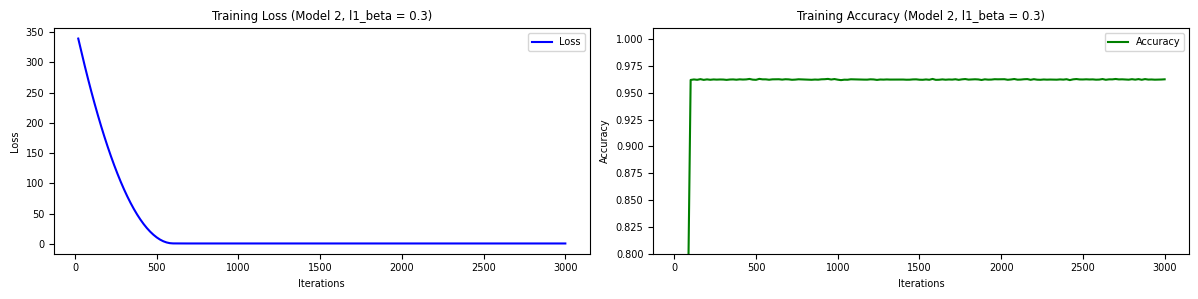

In [79]:
avg_losses = []
avg_accuracies = []
report_freq = 20
for i in range(report_freq - 1, len(losses), report_freq):
    avg_losses.append(sum(losses[i-report_freq+1:i+1]) / report_freq)
    avg_accuracies.append(sum(accuracies[i-report_freq+1:i+1]) / report_freq)

iterations = range(report_freq, len(losses) + 1, report_freq)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

# Plot Loss
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(iterations, avg_losses, label='Loss', color='blue')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss (Model 2, l1_beta = 0.3)')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(iterations, avg_accuracies, label='Accuracy', color='green')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.01)
plt.title('Training Accuracy (Model 2, l1_beta = 0.3)')
plt.legend()

plt.tight_layout()
plt.show()

### Plot weight matrix

Max weight value in weight_hh_l1: 0.0001613511994946748


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


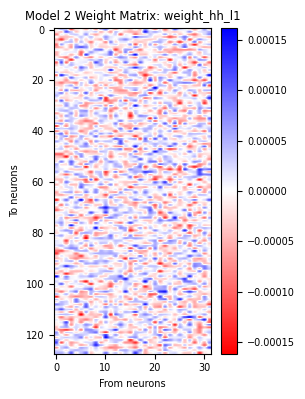

In [61]:
weight_name = 'weight_hh_l1'  # Replace with the desired weight matrix name

W = getattr(net.lstm, weight_name).detach().numpy()
wlim = np.max(np.abs(W))
print(f'Max weight value in {weight_name}: {wlim}')


plt.figure(figsize=(3, 4))
plt.imshow(W, cmap='bwr_r',vmin=-wlim, vmax=wlim, aspect='auto')  # 'aspect=auto' ensures good scaling
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title(f'Model 2 Weight Matrix: {weight_name}')

plt.tight_layout()
plt.show()

### Testing

In [58]:
dataset = ngym.Dataset(config['envid'], env_kwargs=config['env_kwargs'], batch_size=1, seq_len=config['seq_len']) # Generate dataset
env = dataset.env # Reset environment

env.reset(no_step=True)
all_activity = []
all_labels = []

for i in range(1000):
    env.new_trial()
    test_inputs, test_labels = dataset()
    test_inputs = torch.from_numpy(test_inputs).type(torch.float)
    test_labels = torch.from_numpy(test_labels.flatten()).type(torch.long)
    test_accs = []
    with torch.no_grad():
        test_output, act = net(test_inputs)
        test_output = test_output.view(-1, output_size)
        criterion = nn.CrossEntropyLoss()
        test_loss = criterion(test_output, test_labels)
        all_activity.append(act.numpy())
        all_labels.append(test_labels.numpy())
        test_acc = (torch.argmax(test_output, dim=1) == test_labels).sum().item() / test_labels.shape[0]
        test_accs.append(test_acc)

print('Test Accuracy:', np.mean(test_accs))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Test Accuracy: 0.96


### PCA

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


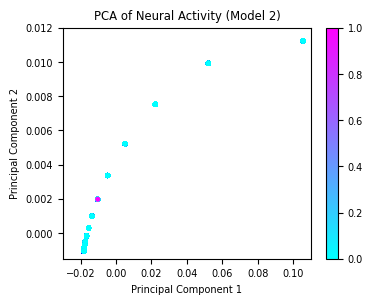

In [80]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

activity = np.vstack(all_activity)
labels = np.concatenate(all_labels)

num_trials, seq_len, num_features = activity.shape
activity = activity.reshape(num_trials, seq_len * num_features)

pca_result = PCA(n_components=2).fit_transform(activity)

plt.figure(figsize=(4, 3))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='cool' ,s=7)
plt.colorbar()  # Color by test labels
plt.title('PCA of Neural Activity (Model 2)')
plt.xlim(-0.03, 0.11)  # Set x-axis limits
plt.ylim(-0.0015, 0.012) # Set y-axis limits
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [83]:
print(all_labels[0]==1)
print(labels.shape)

[False False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False]
(50000,)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
